In [1]:
from soap_utils import *
from dataset import *
from model import AttentionMIL
from model_enhanced import *
from model_hybrid import *
import numpy as np
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import pandas as pd
import os
import pickle
from typing import List, Tuple, Dict, Optional

In [2]:
# Parameters
cif_dir = "../CIF_files"
target_path = './id_labels.csv'
soap_params = {"r_cut": 5.0, "n_max": 1, "l_max": 1, "periodic": True}
max_envs = 200
n_workers = 8
batch_size = 16
embed_dim = 128
attention_dim = 64
learning_rate = 1e-3
epochs = 10

In [3]:
folder_path = '../CIF_files'
n_max = 1
l_max = 1

In [4]:
soap_file_path = 'soap_2d_matrices.npz'
metadata_file_path = 'soap_2d_metadata.pkl'
labels_file_path = 'id_labels.csv'

In [5]:
dataset, matched_ids = create_soap_dataset(
    soap_file_path=soap_file_path,
    metadata_file_path=metadata_file_path,
    labels_file_path=labels_file_path
)

Loading SOAP matrices...
Loaded 3089 SOAP matrices
Each matrix has 484 features
Loading labels...
Loaded 3089 labels
Columns: ['id', 'label']
Matching SOAP matrices with labels...
✓ Successfully matched: 3089 samples
⚠ Unmatched SOAP matrices: 0
⚠ Unmatched labels: 0

=== Dataset Created Successfully ===
Total samples: 3089
SOAP matrix shape example: (123, 484)
Target range: [0.006, 37.706]


In [6]:
train_dataset, val_dataset, test_dataset, split_info = split_dataset(
    dataset, matched_ids,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)


=== Dataset Split ===
Total samples: 3089
Train: 2162 (70.0%)
Validation: 463 (15.0%)
Test: 464 (15.0%)


In [7]:
train_dataloader, val_dataloader, test_dataloader = create_split_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=32,
    num_workers=0
)


=== Creating DataLoaders ===
Batch size: 32
Train batches: 68
Validation batches: 15
Test batches: 15


In [14]:
# Debug version - this will show exactly what's happening
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hybrid_model = train_hybrid_model(train_dataloader, val_dataloader, input_dim=484)

# print(f"DEBUG: hybrid_model = {hybrid_model}")
# print(f"DEBUG: type = {type(hybrid_model)}")

# if hybrid_model is None:
#     print("ERROR: Function returned None!")
    # Let's create it manually
hybrid_model = HybridAttentionLGB(
    input_dim=484,
    embed_dim=256,
    attention_dim=128, 
    feature_dim=128
)
hybrid_model.feature_extractor = hybrid_model.feature_extractor.to(device)

# Pre-train
pretrain_attention_extractor(
    hybrid_model.feature_extractor,
    train_dataloader,
    val_dataloader, 
    device,
    epochs=12,
    feature_dim=128
)

# Train LightGBM
hybrid_model.train(train_dataloader, val_dataloader, device=device)

# Now evaluate
results = evaluate_hybrid_model(hybrid_model, test_dataloader)

Epoch   0: Train Loss: 68.9004, Val Loss: 31.0611
Epoch  10: Train Loss: 19.4921, Val Loss: 18.2259
Pre-training completed! Best Val Loss: 18.2259
Extracting features from training data...
Extracting features from validation data...
Training LightGBM with 516 features...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.91663
[200]	valid_0's rmse: 3.90796
Early stopping, best iteration is:
[157]	valid_0's rmse: 3.89831
LightGBM training completed!
=== Hybrid Model Test Results ===
Test RMSE: 4.1037
Test MAE: 3.2048
Test R²: 0.7190


In [8]:
# Train hybrid model
hybrid_model = train_hybrid_model(train_dataloader, val_dataloader, input_dim=484)

# Evaluate
results = evaluate_hybrid_model(hybrid_model, test_dataloader)

=== Step 1: Pre-training Attention Feature Extractor ===
Epoch   0: Train Loss: 71.3002, Val Loss: 34.9041
Epoch  10: Train Loss: 22.6275, Val Loss: 19.2834
Epoch  20: Train Loss: 16.6154, Val Loss: 18.1924
Epoch  30: Train Loss: 14.6974, Val Loss: 16.7260
Epoch  40: Train Loss: 13.4788, Val Loss: 16.2114
Pre-training completed! Best Val Loss: 15.5202
=== Step 2: Training LightGBM on Attention Features ===
Extracting features from training data...
Extracting features from validation data...
Training LightGBM with 516 features...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.98499
Early stopping, best iteration is:
[145]	valid_0's rmse: 3.96183
Hybrid model training completed!


AttributeError: 'NoneType' object has no attribute 'predict'

In [10]:
# 6. Instantiate model, loss, optimizer
input_dim = 484
epochs = 50
# model = AttentionMIL(input_dim=input_dim, embed_dim=embed_dim, attention_dim=attention_dim)
# model = EnhancedAttentionMIL(
#     input_dim=input_dim,
#     embed_dim=256,  # Increased from 128
#     attention_dim=128,
#     num_heads=4,
#     dropout=0.15
# )
model = ResidualAttentionMIL(
    input_dim=484,
    embed_dim=256,
    attention_dim=128,
    dropout=0.15
)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# 7. Training loop with progress bar
for epoch in range(1, epochs + 1):
    model.train()
    epoch_losses = []
    for x, mask, y in tqdm(train_dataloader, desc=f'Epoch {epoch}/{epochs}'):
        preds, attn = model(x, mask)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    avg_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch}/{epochs} — Avg Loss: {avg_loss:.4f}")

Epoch 1/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1/50 — Avg Loss: 120.2069


Epoch 2/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2/50 — Avg Loss: 72.1036


Epoch 3/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3/50 — Avg Loss: 63.9368


Epoch 4/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4/50 — Avg Loss: 58.6123


Epoch 5/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5/50 — Avg Loss: 46.2706


Epoch 6/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6/50 — Avg Loss: 41.1446


Epoch 7/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 7/50 — Avg Loss: 36.9216


Epoch 8/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8/50 — Avg Loss: 32.4511


Epoch 9/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9/50 — Avg Loss: 30.5190


Epoch 10/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10/50 — Avg Loss: 29.1526


Epoch 11/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11/50 — Avg Loss: 28.2408


Epoch 12/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 12/50 — Avg Loss: 28.7682


Epoch 13/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 13/50 — Avg Loss: 26.4869


Epoch 14/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 14/50 — Avg Loss: 27.2017


Epoch 15/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15/50 — Avg Loss: 25.2350


Epoch 16/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 16/50 — Avg Loss: 24.1717


Epoch 17/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 17/50 — Avg Loss: 23.6140


Epoch 18/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 18/50 — Avg Loss: 23.1945


Epoch 19/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 19/50 — Avg Loss: 22.7667


Epoch 20/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 20/50 — Avg Loss: 23.1055


Epoch 21/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 21/50 — Avg Loss: 23.1252


Epoch 22/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 22/50 — Avg Loss: 22.6231


Epoch 23/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 23/50 — Avg Loss: 22.6748


Epoch 24/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 24/50 — Avg Loss: 21.8507


Epoch 25/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 25/50 — Avg Loss: 21.9599


Epoch 26/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 26/50 — Avg Loss: 21.3357


Epoch 27/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 27/50 — Avg Loss: 22.1309


Epoch 28/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 28/50 — Avg Loss: 21.5464


Epoch 29/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 29/50 — Avg Loss: 21.0223


Epoch 30/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 30/50 — Avg Loss: 20.8455


Epoch 31/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 31/50 — Avg Loss: 20.4500


Epoch 32/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 32/50 — Avg Loss: 20.2669


Epoch 33/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 33/50 — Avg Loss: 20.8271


Epoch 34/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 34/50 — Avg Loss: 20.7604


Epoch 35/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 35/50 — Avg Loss: 20.8751


Epoch 36/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 36/50 — Avg Loss: 19.9693


Epoch 37/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 37/50 — Avg Loss: 20.0789


Epoch 38/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 38/50 — Avg Loss: 20.0070


Epoch 39/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 39/50 — Avg Loss: 20.5013


Epoch 40/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 40/50 — Avg Loss: 19.8055


Epoch 41/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 41/50 — Avg Loss: 20.9987


Epoch 42/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 42/50 — Avg Loss: 19.8051


Epoch 43/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 43/50 — Avg Loss: 19.4748


Epoch 44/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 44/50 — Avg Loss: 19.9051


Epoch 45/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 45/50 — Avg Loss: 19.9817


Epoch 46/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 46/50 — Avg Loss: 19.3590


Epoch 47/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 47/50 — Avg Loss: 20.0154


Epoch 48/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 48/50 — Avg Loss: 19.3852


Epoch 49/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 49/50 — Avg Loss: 19.2814


Epoch 50/50:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 50/50 — Avg Loss: 18.9340


Evaluating on test dataset...


Testing:   0%|          | 0/15 [00:00<?, ?it/s]


=== Test Results ===
Test Loss (MSE): 20.7790
Test RMSE: 4.5809
Test MAE: 3.7273
Test R²: 0.6498
Plot saved to test_predictions.png


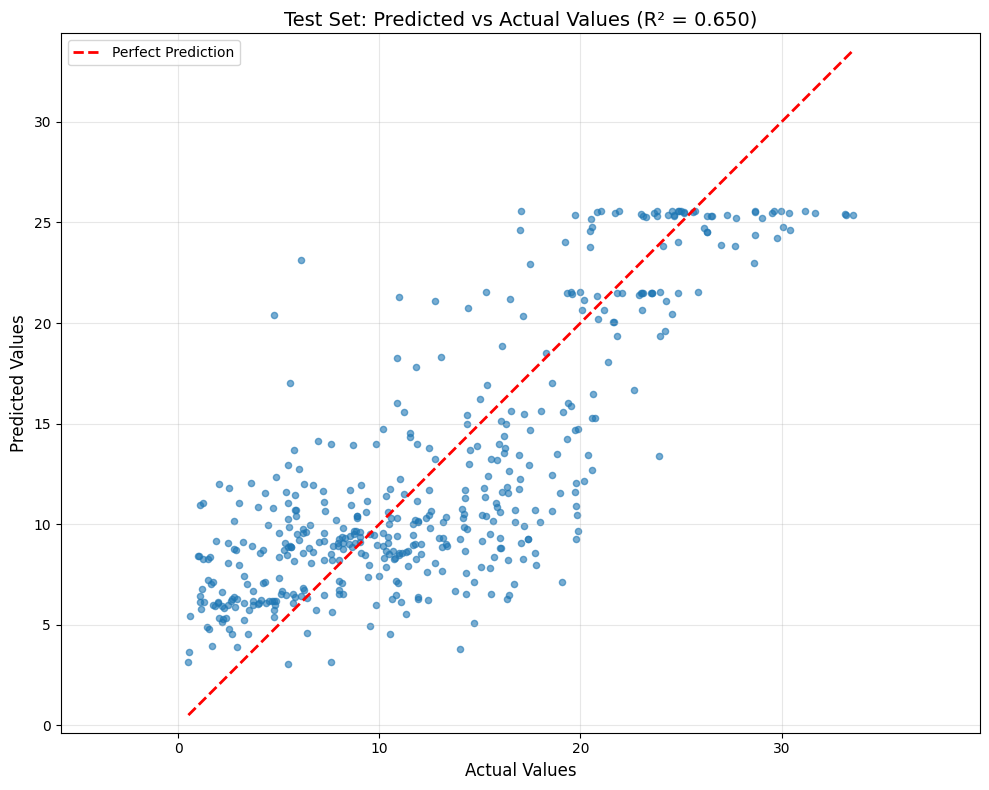

Residuals plot saved to test_residuals.png


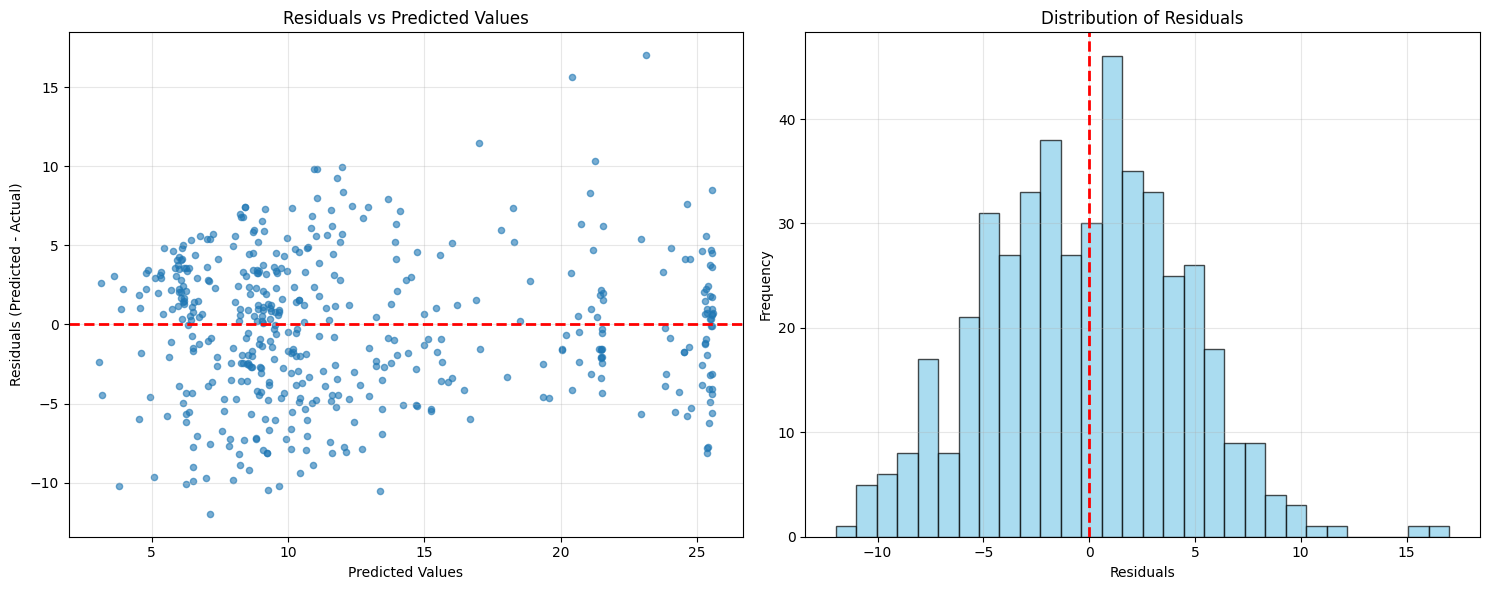

Detailed results saved to 'test_results_detailed.csv'

=== Additional Statistics ===
Mean Absolute Percentage Error: 64.70%
Max Absolute Error: 17.0243
Min Absolute Error: 0.0225
Std of Residuals: 4.5804


In [12]:
# 8. Evaluate on test dataset
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, test_dataloader, device='cpu'):
    """
    Evaluate the trained model on test dataset
    """
    model.eval()
    
    all_predictions = []
    all_targets = []
    all_losses = []
    
    loss_fn = nn.MSELoss()
    
    print("Evaluating on test dataset...")
    
    with torch.no_grad():
        for x, mask, y in tqdm(test_dataloader, desc='Testing'):
            # Move to device if using GPU
            x = x.to(device)
            mask = mask.to(device) 
            y = y.to(device)
            
            # Forward pass
            preds, attn = model(x, mask)
            loss = loss_fn(preds, y)
            
            # Store results
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            all_losses.append(loss.item())
    
    # Convert to numpy arrays
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    
    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)
    
    # Print results
    print(f"\n=== Test Results ===")
    print(f"Test Loss (MSE): {np.mean(all_losses):.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")
    
    return {
        'predictions': predictions,
        'targets': targets,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'test_loss': np.mean(all_losses)
    }

def plot_predictions(results, save_path=None):
    """
    Plot predicted vs actual values
    """
    predictions = results['predictions']
    targets = results['targets']
    r2 = results['r2']
    
    plt.figure(figsize=(10, 8))
    
    # Scatter plot
    plt.scatter(targets, predictions, alpha=0.6, s=20)
    
    # Perfect prediction line
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Labels and title
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title(f'Test Set: Predicted vs Actual Values (R² = {r2:.3f})', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Make plot square
    plt.axis('equal')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

def plot_residuals(results, save_path=None):
    """
    Plot residuals (prediction errors)
    """
    predictions = results['predictions']
    targets = results['targets']
    residuals = predictions - targets
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residuals vs Predicted
    ax1.scatter(predictions, residuals, alpha=0.6, s=20)
    ax1.axhline(y=0, color='r', linestyle='--', lw=2)
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals (Predicted - Actual)')
    ax1.set_title('Residuals vs Predicted Values')
    ax1.grid(True, alpha=0.3)
    
    # Histogram of residuals
    ax2.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Residuals')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Residuals plot saved to {save_path}")
    
    plt.show()

# Run evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Evaluate the model
test_results = evaluate_model(model, test_dataloader, device)

# Plot results
plot_predictions(test_results, save_path='test_predictions.png')
plot_residuals(test_results, save_path='test_residuals.png')

# Optional: Save detailed results
import pandas as pd

# Create detailed results DataFrame
results_df = pd.DataFrame({
    'actual': test_results['targets'],
    'predicted': test_results['predictions'],
    'residual': test_results['predictions'] - test_results['targets'],
    'abs_error': np.abs(test_results['predictions'] - test_results['targets'])
})

# Save to CSV
results_df.to_csv('test_results_detailed.csv', index=False)
print("Detailed results saved to 'test_results_detailed.csv'")

# Print summary statistics
print(f"\n=== Additional Statistics ===")
print(f"Mean Absolute Percentage Error: {np.mean(np.abs(results_df['residual'] / results_df['actual']) * 100):.2f}%")
print(f"Max Absolute Error: {results_df['abs_error'].max():.4f}")
print(f"Min Absolute Error: {results_df['abs_error'].min():.4f}")
print(f"Std of Residuals: {results_df['residual'].std():.4f}")

In [ ]:
0.622
0.667
0.650
0.696
0.7142
0.7441 ( 10 epoch pre_training)

In [11]:
# Parameters
cif_dir = "../CIF_files"
target_path = "./targets.npy"  # npy file matching CIF names order
soap_params = {
    "rcut": 5.0,
    "nmax": 1,
    "lmax": 1,
    "periodic": True,
}

# Load SOAP descriptors
soap_data, cif_names, species = load_structures_and_compute_soaps(
    cif_dir=cif_dir,
    soap_params=soap_params,
    max_envs=200
)

# Load targets
targets_array = np.load(target_path)
assert len(targets_array) == len(soap_data), "Mismatch in number of targets and CIF files"

# Create Dataset and DataLoader
dataset = SOAPDataset(soap_data, targets_array)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=mil_collate_fn)

# Inspect first batch
for batch_x, batch_mask, batch_targets in dataloader:
    print("Batch SOAP shape:", batch_x.shape)
    print("Batch mask shape:", batch_mask.shape)
    print("Batch targets:", batch_targets)
    break

NameError: name 'load_structures_and_compute_soaps' is not defined